In [1]:
# import inspect  ### tool to inspect the code of an imported function

In [2]:
import gammapy
print(gammapy.__version__)

0.19


In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler, Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.maps import MapAxis, WcsGeom, Map, MapAxes, MapCoord
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
#     Model,
#     Models,
    SkyModel,
#     PowerLawSpectralModel,
#     PowerLawNormSpectralModel,
#     PointSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
#     TemplateSpatialModel,
#     ExpDecayTemporalModel,
#     LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
)
from gammapy.maps.geom import pix_tuple_to_idx
import warnings

In [4]:
class EventDataset():
    stat_type = "cash"
    tag = "EventDataset"
    
    def __init__(self, MapDataset, events_table, name='test-eds'):
        """
        MapDataset: gammapy.datasets.MapDataset with the IRFs
        events_table: astropy.table.Table with the event data
        """
        self.ds = MapDataset.copy(name=MapDataset.name)
        self.ds.models = MapDataset.models.copy()
        self.tab = events_table
        self.name = name
        self.meta_table=None
        
    @property
    def models(self):
        return self.ds.models
    
    def npred_sliced(self):
        # for now just slice in energy
        npred = self.ds.npred()
        axis = npred.geom.axes['energy']
        lower, upper = dataset.energy_range_safe
        i,j = lower.data.shape
        idx_min = axis.coord_to_idx(lower.data[i//2,j//2])
        idx_max = axis.coord_to_idx(upper.data[i//2,j//2])
        
        if idx_min == -1: idx_min = None
        if idx_max == -1: idx_max = None
        
        return npred.slice_by_idx({'energy':slice(idx_min,idx_max+1)})
        
        
    def stat_sum(self):
        """
        Calculating the TS value for the unbinned dataset. 
        Essentially interpolating the npred cube at the events 
        positions (ra,dec,energy) and summing the log of those values.
        """
        npred = self.ds.npred()
        # need to mask the total npred so only regions contibute where events are
        mask = self.ds.mask_safe.data
        # maybe only count npred where counts are present
#         mask2 = self.ds.counts.data > 0
#         mask &= mask2
        npred_tot = npred.data[mask].sum()
        # set the event coords from table
        coords = MapCoord.create((self.tab["RA"].quantity.to('deg'),
                                 self.tab["DEC"].quantity.to('deg'),
                                 self.tab["ENERGY"].quantity.to('TeV')), 
                                 frame='icrs', axis_names=['energy'])
        # interpolate the predicted counts
        axis = npred.geom.axes['energy']
        lower, upper = dataset.energy_range_safe
        i,j = lower.data.shape
        idx_min = axis.coord_to_idx(lower.data[i//2,j//2])[0]
        idx_max = axis.coord_to_idx(upper.data[i//2,j//2])[0]
        
        if idx_min == -1: idx_min = None
        if idx_max == -1: idx_max = None      
        npredS= npred.slice_by_idx({'energy':slice(idx_min,idx_max+1)})
    
        response = npredS.interp_by_coord(coords, method='linear')
        # if npred = 0 at some events position the model is rouled out (TS=inf)
        if np.all(response>0):
            logL = np.sum(np.log(response)) - npred_tot
        else:
#             print(np.where(response==0))
            return np.inf
        return -2 * logL

    def contribution_events(self):
        """
        compute the contribution of each event to the total likelihood
        """
        nevents = len(self.tab)
        npred = self.ds.npred()
        mask = self.ds.mask_safe.data
        npred_tot = npred.data[mask].sum()
        # set the event coords from table
        coords = MapCoord.create((self.tab["RA"].quantity.to('deg'),
                                 self.tab["DEC"].quantity.to('deg'),
                                 self.tab["ENERGY"].quantity.to('TeV')), 
                                 frame='icrs', axis_names=['energy'])
        # interpolate the predicted counts
        axis = npred.geom.axes['energy']
        lower, upper = dataset.energy_range_safe
        i,j = lower.data.shape
        idx_min = axis.coord_to_idx(lower.data[i//2,j//2])[0]
        idx_max = axis.coord_to_idx(upper.data[i//2,j//2])[0]
        
        if idx_min == -1: idx_min = None
        if idx_max == -1: idx_max = None      
        npredS= npred.slice_by_idx({'energy':slice(idx_min,idx_max+1)})
        response = npredS.interp_by_coord(coords, method='linear')
#         return response
        return (np.log(response) - npred_tot/nevents) * -2.
    
    def contribution_bins(self):
        """
        compute the contribution of each event in the binned likelihood
        """
        
        stat_array = self.ds.stat_array()
        counts = self.ds.counts
        contrib=[]
        indices=[]
        coordinates=[]
        for row in self.tab:
            c=MapCoord.create((row["RA"]*self.tab["RA"].unit,
                                 row["DEC"]*self.tab["DEC"].unit,
                                 row["ENERGY"]*self.tab["ENERGY"].unit), 
                                 frame='icrs', axis_names=['energy'])
            idx = counts.geom.coord_to_idx(c)
            nevents = counts.get_by_idx(idx)
            contrib.append(stat_array.T[idx]/nevents)
            indices.append(idx)
            coordinates.append(c)
        return np.array(contrib), np.array(indices), np.array(coordinates)

* Thoughts on masking: But even more important for the fitting is the part of npred which I mask. If I don't apply any mask the background is fitted very low because it increases npred more than the events account for (the bkg model is punished too much by the npred outside the mask). But if I mask all pixels where I don't see any counts the source spectrum is fitted to 0 and the background dominates (too little punishment because it is seen as a model directly at the counts positions). I get rather consistent results when applying the safe_mask but since the results are so sensitive to the mask we should think what is the correct way of doing this.

* Because of the linear inperpolation the bins just outside the mask_safe can have an strong influence on events which have coords in between the centers from the pixels inside and outside the mask. So huge model contributions outside are not punished but lead to too large interpolation values for those events.  

* * Fix1: Evaluate the model at the pixel edges and interpolate this npred map. However for the integration over the predicted counts one would need the npred map evaluated at the centers. So one would end up with two evaluations of npred which might be slow.
* * Fix2: Just ignore the pixels outside the mask for the interpolation and perform an extrapolation for events between the very edge and the last center. This is not optimal but should be fine with not too rough binning.
* * Fix3: Sum npred also in one index around mask_safe. The additional npred will distort the fit a bit but maybe not too much.

* Thoughts on fill_value: For event coordinates which are beyond an edge pixel center the problem is that they are interpolated to fill_value, i.e. an event with 99 TeV when the energy axis goes to 100 TeV but the last center is at 90 TeV.

# Create Binned MapDataset

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

In [6]:
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]
# selection = dict(
#     type="sky_circle",
#     frame="icrs",
#     lon="83.633 deg",
#     lat="22.014 deg",
#     radius="5 deg",
# )
# selected_obs_table = data_store.obs_table.select_observations(selection)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None


In [7]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos = obs1.pointing_radec
# choose energy binning
ebins = np.geomspace(0.6,100,25)
ebins_true = np.logspace(-1,2,73)

energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins_true, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.05,
    width=(3.5, 3.5),
    frame="icrs",  # same frame as events
    proj="CAR",
    axes=[energy_axis],
)

circle = CircleSkyRegion(
    center=crab_pos, radius=0.3 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [43]:
%%time
maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'aeff-default'], offset_max='1.5 deg')
# providing the migra axis seems essential so that edisp is a EdispMap and no EdispKernelMap
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)  

dataset = maker.run(reference, obs1)
dataset = maker_safe_mask.run(dataset, obs1)

# assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
# dataset.background.data[~dataset.mask_safe.data] = 0.0

bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models=bkg_model
# dataset.background_model.spectral_model.tilt.frozen = False
# dataset = maker_fov.run(dataset)
# print(
#     f"Background norm obs {obs1.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f} \
#     (tilt={dataset.background_model.spectral_model.tilt.value:.2f})"
# )

CPU times: user 3.42 s, sys: 392 ms, total: 3.81 s
Wall time: 3.79 s


In [44]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

model_gauss.spatial_model.parameters.freeze_all()
model_gauss.spectral_model.amplitude.min = 0.
model_gauss.spectral_model.alpha.min = 0.
model_gauss.spectral_model.beta.min = 0.

model_gauss.spectral_model.amplitude.max = 3.5e-11
model_gauss.spectral_model.alpha.max = 5
model_gauss.spectral_model.beta.max = 4

model_gauss.parameters.to_table()

model_ref = model_gauss.copy()

In [45]:
dataset.models += model_gauss

In [46]:
print(dataset)

MapDataset
----------

  Name                            : -_EpRSFX 

  Total counts                    : 1385 
  Total background counts         : 1332.99
  Total excess counts             : 52.01

  Predicted counts                : 1348.89
  Predicted background counts     : 1332.99
  Predicted excess counts         : 15.91

  Exposure min                    : 3.35e+06 m2 s
  Exposure max                    : 1.10e+09 m2 s

  Number of total bins            : 117600 
  Number of fit bins              : 59388 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11023.51

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 4

  Component 0: FoVBackgroundModel
  
    Name                      : -_EpRSFX-bkg
    Datasets names            : ['-_EpRSFX']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :      1.000   +/-    0.00             
      

In [ ]:
%%time
### Compare analysis for n MC simulations
n=100
pointing = obs1.pointing_radec
params=dataset.models.parameters.free_parameters.names # ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
x_values = np.arange(len(params))
par_input=[dataset.models.parameters[par].value for par in params]

par_binned=[]
err_binned=[]
par_unbin =[]
err_unbin =[]
dTS_binned = []
dTS_unbinned = []

for ii in range(n):
    ### draw random revents
    for i,par in enumerate(params):
        dataset.models.parameters.free_parameters[par].value = par_input[i]
    sampler = MapDatasetEventSampler(random_state=ii)
    events = sampler.run(dataset, obs1)
    
    ### set up binned and unbinned datasets
    counts = Map.from_geom(geom)
    counts.fill_events(events)
    dataset.counts=counts
    ev_table=events.table[["EVENT_ID",
                            "TIME",
                            "RA",
                            "DEC", 
                            "ENERGY",]]
    
    event_skycoords = SkyCoord(ev_table["RA"].quantity, 
                               ev_table["DEC"].quantity, frame = 'icrs')
    mask_offset = pointing.separation(event_skycoords).to_value('deg')<=1.5

    lower, upper = dataset.energy_range_safe
    k,j = lower.data.shape
    emin=lower.data[k//2,j//2] * lower.unit  # emin from central pixels
    emax=upper.data[k//2,j//2] * upper.unit  # emax from central pixels
    tab_mask = (ev_table['ENERGY'] >= emin) & \
                (ev_table['ENERGY'] <= emax) &\
                mask_offset &  (ev_table["RA"]>60*u.deg)
    eds = EventDataset(dataset, ev_table[tab_mask])
    
    ### fit both datasets
    fit = Fit(optimize_opts={"print_level": 0})
    result = fit.run([dataset])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result2 = fit.run([eds])
        
    ### parameter comparison
    par_binned.append([result.parameters[par].value for par in params])
    err_binned.append([result.parameters[par].error for par in params])

    par_unbin.append([result2.parameters[par].value for par in params])
    err_unbin.append([result2.parameters[par].error for par in params])
    
    ### test of the source significance
    ts_binned = result.total_stat
    ts_unb = result2.total_stat
    print(f"{ii}: TS_binned = {ts_binned:.2f}; TS_unbinned = {ts_unb:.2f}")
    with dataset.models.parameters.restore_status():
        dataset.models.parameters['amplitude'].value = 0
        dataset.models.parameters['amplitude'].frozen = True
        res=fit.optimize(dataset)
        ts_binned0 = res.total_stat
    with eds.models.parameters.restore_status():
        eds.models.parameters['amplitude'].value = 0
        eds.models.parameters['amplitude'].frozen = True
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res2=fit.optimize([eds])
        ts_unb0 = res2.total_stat
    dTS_binned.append(ts_binned0-ts_binned)
    dTS_unbinned.append(ts_unb0-ts_unb)

0: TS_binned = 10850.30; TS_unbinned = 10841.40
1: TS_binned = 10847.89; TS_unbinned = 10839.02
2: TS_binned = 10876.00; TS_unbinned = 10857.29
3: TS_binned = 10847.82; TS_unbinned = 10822.87
4: TS_binned = 11055.48; TS_unbinned = 11068.61
5: TS_binned = 10909.74; TS_unbinned = 10963.45
6: TS_binned = 10848.76; TS_unbinned = 10812.66
7: TS_binned = 10804.13; TS_unbinned = 10839.98
8: TS_binned = 11118.42; TS_unbinned = 11065.65
9: TS_binned = 10886.48; TS_unbinned = 10858.94


In [48]:
par_bin_mean = np.mean(par_binned, axis=0)
par_ubin_mean = np.mean(par_unbin, axis=0)

err_bin_mean = np.mean(err_binned, axis=0)
err_ubin_mean = np.mean(err_unbin, axis=0)

dTS_binned_mean = np.mean(dTS_binned)
dTS_unbinned_mean = np.mean(dTS_unbinned)
print(f"Avg over {n} simulations: \n" +
        f"deltaTS binned   = {dTS_binned_mean:.3f} \n" +
        f"deltaTS unbinned = {dTS_unbinned_mean:.3f}")

par_binned=np.array(par_binned)
par_unbin=np.array(par_unbin)
err_binned=np.array(err_binned)
err_unbin=np.array(err_unbin)
dTS_binned=np.array(dTS_binned)
dTS_unbinned=np.array(dTS_unbinned)
   

Avg over 100 simulations: 
deltaTS binned   = 12.058 
deltaTS unbinned = 12.140


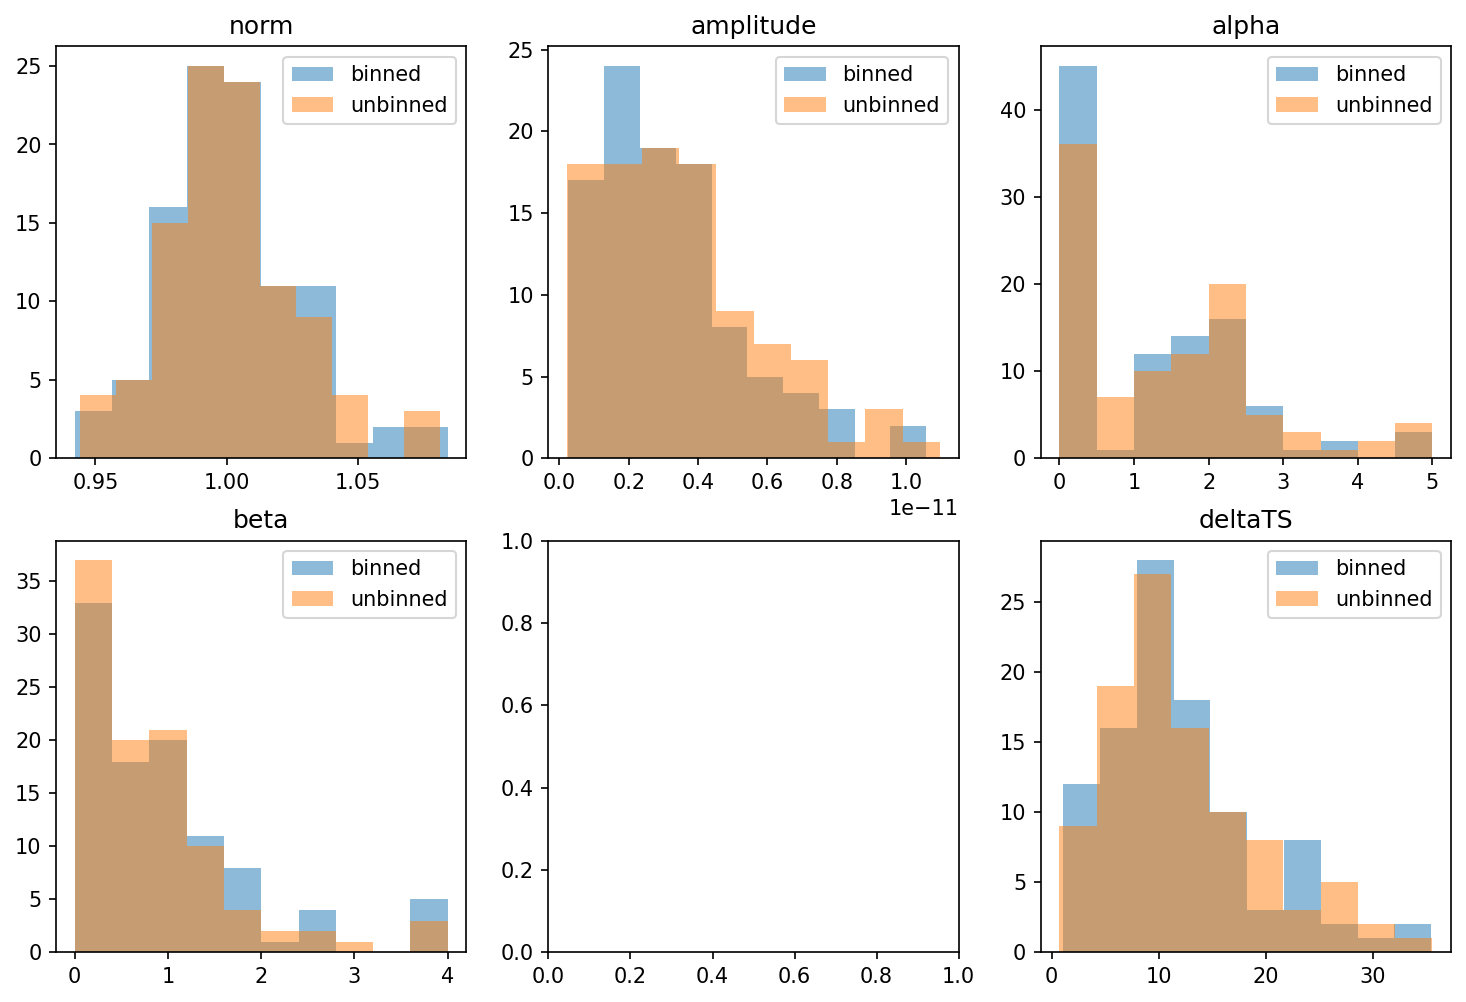

In [49]:
fig, axes = plt.subplots(2,3,dpi=150, figsize=(12,8))
for i,par in enumerate(params):
    ax=axes.flat[i]
    
    ax.hist(par_binned[:,i], alpha=0.5, label='binned')
    ax.hist(par_unbin[:,i], alpha=0.5, label='unbinned')
    ax.set_title(par)
    ax.legend()
    
ax=axes.flat[-1]
ax.hist(dTS_binned, alpha=0.5, label='binned')
ax.hist(dTS_unbinned, alpha=0.5, label='unbinned')
ax.set_title('deltaTS')
ax.legend()

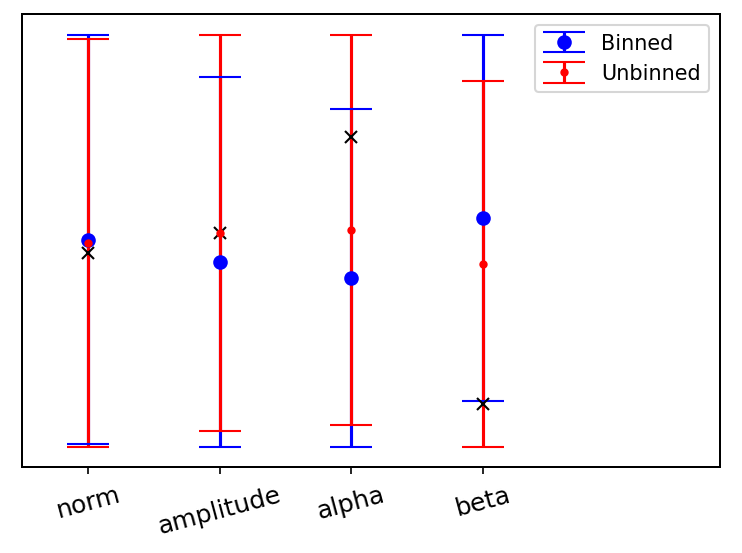

In [50]:
fig,ax = plt.subplots(dpi=150)
for i,par in enumerate(params):
    if i == 0:
        axi = ax
        label = ['Binned', 'Unbinned']
    else:
        axi = ax.twinx()
        label = None, None
    axi.errorbar(i, par_bin_mean[i],yerr=err_bin_mean[i], 
                 label=label[0],capsize=10, fmt='bo')
    axi.errorbar(i, par_ubin_mean[i],yerr=err_ubin_mean[i], 
                 label=label[1],capsize=10, fmt='ro',markersize=3)
    axi.plot(i, par_input[i], marker='x', ls='None', color='k')
    axi.set_yticks([])
ax.legend()
# ax.set_ylabel('Amplitude [1/(TeV*s*cm²)]')
ax.tick_params(axis='x', rotation=15, labelsize=12)

# ax2.errorbar(1, best_fit_fermi[1], yerr=error_fermi[1], capsize=10, fmt='bo')
# ax2.errorbar(1, best_fit_gp[1],yerr=error_gp[1], label='$\gamma\pi$',capsize=10, fmt='ro')
# ax2.set_ylabel('Alpha scale')

# ax3.errorbar(2, best_fit_fermi[2], yerr=error_fermi[2], capsize=10, fmt='bo')
# ax3.errorbar(2, best_fit_gp[2],yerr=error_gp[2], label='$\gamma\pi$',capsize=10, fmt='ro')
# ax3.set_yticks([])
#ax.set_xticklabels(['amplitude'])
plt.xticks(x_values, params, rotation=20, fontsize=20)
#ax1.set_xticks(rotation = 90)
plt.xlim(-0.5,len(params)+0.8)
plt.show()

In [54]:
par_unbin[:,-1]

array([8.00992496e-01, 9.84924469e-01, 9.34988798e-01, 2.43209019e-01,
       9.54803611e-02, 2.52668099e+00, 1.89542849e-01, 3.49070560e-01,
       7.52109055e-01, 8.02566116e-01, 9.50234708e-01, 6.34854349e-01,
       1.02500261e-08, 3.91784065e-02, 1.07634005e-04, 1.05760320e+00,
       1.65988677e+00, 9.28710269e-02, 4.64419184e-01, 1.84973905e+00,
       1.83065932e-05, 6.87707165e-01, 6.75417349e-01, 1.44957091e-04,
       1.01641395e+00, 1.25127596e+00, 8.47891909e-01, 1.14046331e+00,
       1.16419259e+00, 4.81105405e-01, 2.43694575e-01, 5.33926139e-01,
       9.20620737e-01, 5.63382381e-01, 7.34164924e-01, 1.42697619e+00,
       2.68815118e-06, 5.31839202e-01, 1.41042181e+00, 2.17101808e-08,
       2.51395211e-01, 1.00628633e+00, 3.99993001e+00, 1.34640091e-01,
       1.23526152e+00, 5.50301262e-01, 1.22336079e+00, 1.92968902e-01,
       1.54789680e-01, 4.65521108e-07, 2.82911691e+00, 2.41869120e+00,
       7.12589868e-06, 1.24197027e+00, 1.01871076e+00, 5.29635997e-02,
      

In [55]:
par_binned[:,-1]

array([7.16788329e-01, 1.26723123e+00, 9.82203847e-01, 3.71507013e-01,
       1.69172632e-01, 2.54412287e+00, 3.99989482e+00, 4.23952418e-01,
       8.81820512e-01, 1.11937988e+00, 1.06375249e+00, 6.47390868e-01,
       8.15346379e-08, 8.03009580e-02, 3.77827703e-08, 1.77260107e+00,
       1.81159636e+00, 8.82189844e-02, 5.05297427e-01, 1.81771768e+00,
       6.81249368e-02, 7.54224302e-01, 7.37892055e-01, 1.60716019e-05,
       1.06061739e+00, 1.10827330e+00, 1.00410541e+00, 1.07407318e+00,
       1.25683032e+00, 6.50055320e-01, 4.64641486e-01, 5.12558840e-01,
       6.95031740e-01, 5.13763566e-01, 7.87813605e-01, 1.42717886e+00,
       1.42445637e+00, 7.29527233e-01, 1.35216428e+00, 3.18590289e-07,
       1.24197195e+00, 1.07409464e+00, 3.99998932e+00, 1.72373329e-01,
       1.73392589e+00, 4.28308590e-01, 1.27004854e+00, 2.70679652e-01,
       7.18805459e-02, 9.56191829e-07, 3.73023935e+00, 2.58490024e+00,
       1.00426303e-05, 1.24911336e+00, 1.06805512e+00, 7.02763207e-02,
      

# Look at an individual simulation

In [52]:
np.where(np.array(dTS_unbinned)>400)

(array([21, 62, 71, 74]),)

In [59]:
pointing = obs1.pointing_radec
params=dataset.models.parameters.free_parameters.names # ['amplitude', 'alpha', 'beta', 'norm', 'tilt']
x_values = np.arange(len(params))
par_input=[dataset.models.parameters[par].value for par in params]

In [17]:
for i,par in enumerate(params):
    dataset.models.parameters.free_parameters[par].value = par_input[i]
sampler = MapDatasetEventSampler(random_state=62)
events = sampler.run(dataset, obs1)

print(f"Source events: {(events.table['MC_ID'] == 1).sum()}")
print(f"Background events: {(events.table['MC_ID'] == 0).sum()}")

Source events: 26
Background events: 2911


In [18]:
counts = Map.from_geom(geom)

counts.fill_events(events)
dataset.counts=counts

## Create the Unbinned Dataset
Only use those events that are also filled in the counts cube for better comparison

In [19]:
ev_table=events.table[["EVENT_ID",
                            "TIME",
                            "RA",
                            "DEC", 
                            "ENERGY",]]
#                             'FOV_RADEC_THETA']] # FOV_RADEC_THETA = offset (not present in this event list here)

In [20]:
pointing = obs1.pointing_radec
event_skycoords = SkyCoord(ev_table["RA"].quantity, 
                           ev_table["DEC"].quantity, frame = 'icrs')
mask_offset = pointing.separation(event_skycoords).to_value('deg')<=1.5+0.00 # small tolerance dependent of pixel size

ers = dataset.energy_range_safe[0]
i,j = ers.data.shape
emin=ers.data[i//2,j//2] * ers.unit  # emin from central pixels
tab_mask = (ev_table['ENERGY'] >= emin) & \
            (ev_table['ENERGY'] <= 100.*u.TeV) &\
            mask_offset &  (ev_table["RA"]>60*u.deg)
eds = EventDataset(dataset, ev_table[tab_mask])

In [21]:
# make sure same number of events in both data sets
len(eds.tab),dataset.counts.data[dataset.mask_safe.data].sum()

(1249, 1246.0)

# Fit both datasets and compare

In [22]:
%%time
fit = Fit(optimize_opts={"print_level": 0})
result = fit.run([dataset])
print(result)
result.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 283
	total stat : 10528.05

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 283
	total stat : 10528.05


CPU times: user 2.45 s, sys: 16 ms, total: 2.47 s
Wall time: 2.46 s


type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,norm,8.1734e-01,,3.333e-02,nan,nan,False,
spectral,tilt,-1.6541e-01,,3.537e-02,nan,nan,False,
spectral,amplitude,5.0646e-12,cm-2 s-1 TeV-1,2.966e-12,0.000e+00,nan,False,
spectral,alpha,5.1944e+00,,3.835e+00,0.000e+00,nan,False,
spectral,beta,1.3185e-05,,3.737e-02,0.000e+00,nan,False,


In [23]:
eds.stat_sum()

10550.9069786695

In [24]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result2 = fit.run([eds])
    print(result2)
result2.parameters.free_parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Call limit was reached.
	nfev       : 826
	total stat : 10544.57

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Call limit was reached.
	nfev       : 826
	total stat : 10544.57


CPU times: user 8.27 s, sys: 10 µs, total: 8.27 s
Wall time: 8.26 s


type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,norm,8.2089e-01,,3.170e-02,nan,nan,False,
spectral,tilt,-1.6327e-01,,3.504e-02,nan,nan,False,
spectral,amplitude,3.2290e-16,cm-2 s-1 TeV-1,2.536e-15,0.000e+00,nan,False,
spectral,alpha,2.6497e+01,,1.083e+01,0.000e+00,nan,False,
spectral,beta,3.2398e+00,,3.370e-01,0.000e+00,nan,False,


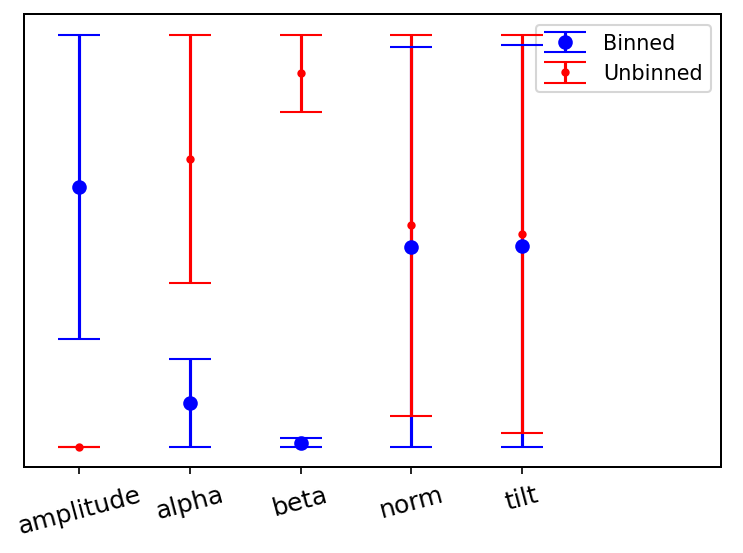

In [25]:
## parameter comparison
params=['amplitude', 'alpha', 'beta', 'norm', 'tilt']
x_values = np.arange(len(params))
best_fit_binned = {par:result.parameters[par].value for par in params}
error_binned = {par:result.parameters[par].error for par in params}

best_fit_unbinned = {par:result2.parameters[par].value for par in params}
error_unbinned = {par:result2.parameters[par].error for par in params}

fig,ax = plt.subplots(dpi=150)
for i,par in enumerate(params):
    if i == 0:
        axi = ax
        label = ['Binned', 'Unbinned']
    else:
        axi = ax.twinx()
        label = None, None
    axi.errorbar(i, best_fit_binned[par],yerr=error_binned[par], 
                 label=label[0],capsize=10, fmt='bo')
    axi.errorbar(i, best_fit_unbinned[par],yerr=error_unbinned[par], 
                 label=label[1],capsize=10, fmt='ro',markersize=3)
    axi.set_yticks([])
ax.legend()
# ax.set_ylabel('Amplitude [1/(TeV*s*cm²)]')
ax.tick_params(axis='x', rotation=15, labelsize=12)

# ax2.errorbar(1, best_fit_fermi[1], yerr=error_fermi[1], capsize=10, fmt='bo')
# ax2.errorbar(1, best_fit_gp[1],yerr=error_gp[1], label='$\gamma\pi$',capsize=10, fmt='ro')
# ax2.set_ylabel('Alpha scale')

# ax3.errorbar(2, best_fit_fermi[2], yerr=error_fermi[2], capsize=10, fmt='bo')
# ax3.errorbar(2, best_fit_gp[2],yerr=error_gp[2], label='$\gamma\pi$',capsize=10, fmt='ro')
# ax3.set_yticks([])
#ax.set_xticklabels(['amplitude'])
plt.xticks(x_values, params, rotation=20, fontsize=20)
#ax1.set_xticks(rotation = 90)
plt.xlim(-0.5,len(params)+0.8)
plt.show()

In [56]:
%%time
fpe = FluxPointsEstimator(energy_axis.edges, source='crab_model_gauss', selection_optional='all')
fp = fpe.run([dataset])

CPU times: user 32.4 s, sys: 411 ms, total: 32.8 s
Wall time: 32.9 s


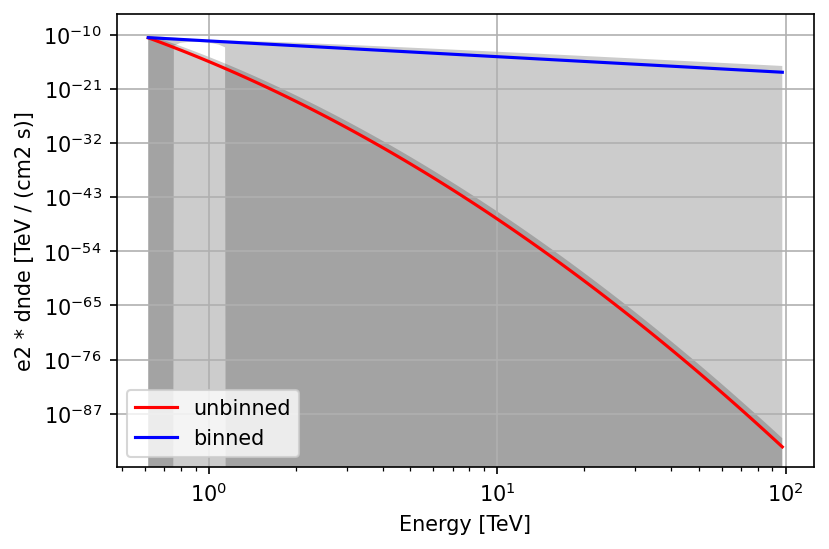

In [26]:
plt.figure(dpi=150)
# fp.plot(color='blue', energy_power=2)
kwargs = dict(energy_bounds=[0.6,100]*u.TeV, energy_power=2)
eds.models['crab_model_gauss'].spectral_model.plot(label='unbinned', c='r', **kwargs)
dataset.models['crab_model_gauss'].spectral_model.plot(label='binned', c='b', **kwargs)
eds.models['crab_model_gauss'].spectral_model.plot_error(color='red', **kwargs)
dataset.models['crab_model_gauss'].spectral_model.plot_error(color='blue', **kwargs)
plt.legend()
plt.grid()

In [27]:
# compute the contributions to the total likelihood for each event
contrib=eds.contribution_events()
contrib_bins, ind, co = eds.contribution_bins()

In [28]:
npred = eds.ds.npred()

In [29]:
npredS=npred.slice_by_idx({'energy':slice(2,25)})

In [30]:
npred.data.shape, npredS.data.shape

((24, 70, 70), (22, 70, 70))

In [31]:
eds.ds.mask_safe.data[:,30,30]

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False])

In [32]:
dataset.energy_range_safe[0].data[20,10],dataset.energy_range_safe[1].data[30,30]

(0.9189784193824853, 80.80215968260903)

In [33]:
test=npred.geom.axes[0]

In [34]:
s,t=test.coord_to_idx([0.9189784193824853, 80.80215968260903])

In [35]:
slice(s,t)

slice(2, 23, None)

In [36]:
npred.data[23,30,30]

4.527291378530857e-06

In [37]:
npredS

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (70, 70, 22)
	ndim  : 3
	unit  : 
	dtype : float64

In [38]:
npred.data[eds.ds.mask_safe.data].sum()

1249.5923328178837

In [39]:
np.where(contrib<-13)

(array([], dtype=int64),)

In [110]:
coord = MapCoord.create((eds.tab["RA"].quantity[102].to('deg'),
                                 eds.tab["DEC"].quantity[102].to('deg'),
                                 eds.tab["ENERGY"].quantity[102].to('TeV')), 
                                 frame='icrs', axis_names=['energy'])

In [143]:
npredS.interp_by_coord(coord)

array([1.04468608])

In [144]:
npredS.geom.coord_to_pix(coord)

(array([34.8216865]), array([42.15790494]), array([-0.21106732]))

In [145]:
npredS.data[0,42,35]

0.7656940061044059

In [125]:
npred.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [107]:
eds.tab[102]

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float64,float64,float64
263,123891616.20266174,83.61599670398721,21.897338705918692,0.977358384157003


In [108]:
events.table[263]

ENERGY_TRUE,RA_TRUE,DEC_TRUE,TIME,MC_ID,ENERGY,RA,DEC,DETX,DETY,EVENT_ID
TeV,deg,deg,s,,TeV,deg,deg,deg,deg,
float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
0.977358384157003,83.61599670398721,21.897338705918692,123891616.20266174,0,0.977358384157003,83.61599670398721,21.897338705918692,-0.016084324962956455,0.3828952470353205,263


In [98]:
dataset.npred().data[eds.ds.mask_safe.data].sum()

1246.0029507640136

In [99]:
eds.ds.models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,norm,7.8857e-01,,6.702e+04,nan,nan,False,
spectral,tilt,-1.4499e-01,,6.702e+04,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spectral,amplitude,4.1477e-23,cm-2 s-1 TeV-1,6.104e-12,0.000e+00,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spectral,alpha,4.8802e+01,,6.701e+05,0.000e+00,nan,False,
spectral,beta,3.3359e-01,,1.678e-05,0.000e+00,nan,False,
spatial,lon_0,1.8456e+02,deg,0.000e+00,nan,nan,True,
spatial,lat_0,-5.7840e+00,deg,0.000e+00,-9.000e+01,9.000e+01,True,


In [40]:
### check the sum of the contributions
### difference for binned because of empty bins
contrib.sum(), eds.stat_sum(), contrib_bins.sum(), eds.ds.stat_sum()

(10544.56992511478, 10544.569925114778, 8182.1684309068405, 10531.104637182343)

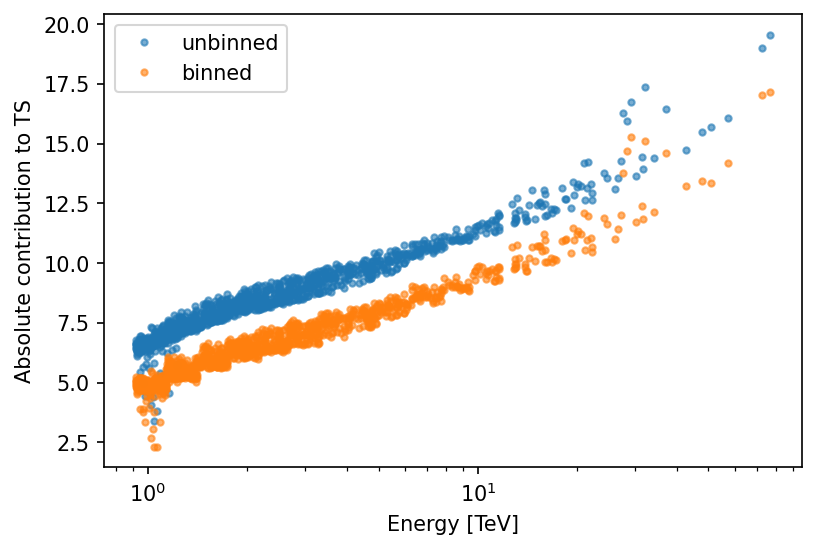

In [41]:
plt.figure(dpi=150)
plt.semilogx(eds.tab["ENERGY"], contrib, ls='None', marker='.', alpha=0.6, label='unbinned')
plt.semilogx(eds.tab["ENERGY"], contrib_bins, ls='None', marker='.', alpha=0.6, label='binned')
plt.xlabel('Energy [TeV]')
plt.ylabel("Absolute contribution to TS")
plt.legend()

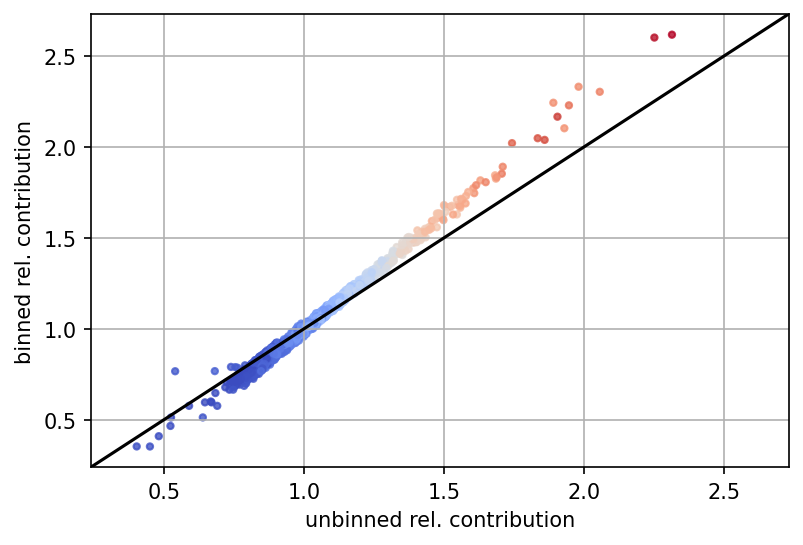

In [42]:
plt.figure(dpi=150)

colormap = plt.cm.coolwarm
colorst = np.log(eds.tab["ENERGY"])
colorst /= colorst.max()

plt.scatter(contrib/contrib.sum()*len(contrib), 
         contrib_bins/contrib_bins.sum()*len(contrib_bins), 
         ls='None', marker='.', color=colormap(colorst), alpha=0.8)
ax = plt.gca()



xlim=ax.get_xlim()
ylim=ax.get_ylim()
sq_lim = min(ylim[0],xlim[0]), max(ylim[1],xlim[1])

plt.plot(sq_lim,sq_lim, c='k')
plt.xlabel('unbinned rel. contribution')
plt.ylabel('binned rel. contribution')
plt.xlim(sq_lim)
plt.ylim(sq_lim)
plt.grid()

# Test of significances

In [73]:
# test of the source significance
ts_binned = dataset.stat_sum()
ts_unb = eds.stat_sum()
print(f"TS_binned = {ts_binned:.2f}; TS_unbinned = {ts_unb:.2f}")
with dataset.models.parameters.restore_status():
    dataset.models.parameters['amplitude'].value = 0
    dataset.models.parameters['amplitude'].frozen = True
    res=fit.optimize(dataset)
    ts_binned0 = res.total_stat
with eds.models.parameters.restore_status():
    eds.models.parameters['amplitude'].value = 0
    eds.models.parameters['amplitude'].frozen = True
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res2=fit.optimize([eds])
    ts_unb0 = res2.total_stat
      
print(f"deltaTS_binned = {ts_binned0-ts_binned:.5f}")
print(f"deltaTS_unbinned = {ts_unb0-ts_unb:.5f}")

TS_binned = 10528.05; TS_unbinned = 10008.73
deltaTS_binned = 6.72502
deltaTS_unbinned = 545.30972


In [74]:
# test of the curvature (beta) significance
ts_binned = dataset.stat_sum()
ts_unb = eds.stat_sum()
print(f"TS_binned = {ts_binned:.2f}; TS_unbinned = {ts_unb:.2f}")
with dataset.models.parameters.restore_status():
    dataset.models.parameters['beta'].value = 0
    dataset.models.parameters['beta'].frozen = True
    res=fit.optimize(dataset)
    ts_binned0 = res.total_stat
with eds.models.parameters.restore_status():
    eds.models.parameters['beta'].value = 0
    eds.models.parameters['beta'].frozen = True
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res2=fit.optimize([eds])
    ts_unb0 = res2.total_stat
      
print(f"deltaTS_binned = {ts_binned0-ts_binned:.5f}")
print(f"deltaTS_unbinned = {ts_unb0-ts_unb:.5f}")

TS_binned = 10528.05; TS_unbinned = 10008.73
deltaTS_binned = -0.00000
deltaTS_unbinned = -752.59610


/home/woody/caph/mppi086h/software/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


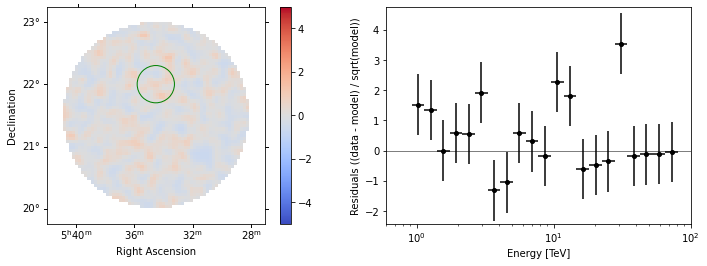

In [75]:
with model_gauss.parameters.restore_status():
    model_gauss.parameters['amplitude'].value = 0
    dataset.plot_residuals(kwargs_spectral={'region':circle, 'method':'diff/sqrt(model)'},
                          kwargs_spatial=dict(vmin=-5,vmax=5, smooth_radius='0.05 deg',method='diff/sqrt(model)'))

# some timing tests

In [65]:
# time for binned dataset
%timeit dataset.stat_sum()

4.27 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
# time for unbinned dataset
%timeit eds.stat_sum()

4.49 ms ± 28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
